# EDA

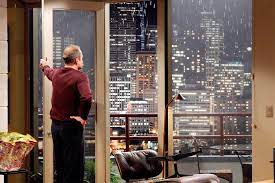

In [13]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import missingno as msno
from geopy.geocoders import Nominatim
import geopandas as gpd
import matplotlib.patches as mpatches

from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Definition of Functions

In [14]:
# Function to calculate distance between two points given latitude and longitude using haversine formula

def distance_haversine(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of Earth in kilometers
    R = 6371
    distance = R * c
    return distance


Read csv file and get some information

<Axes: >

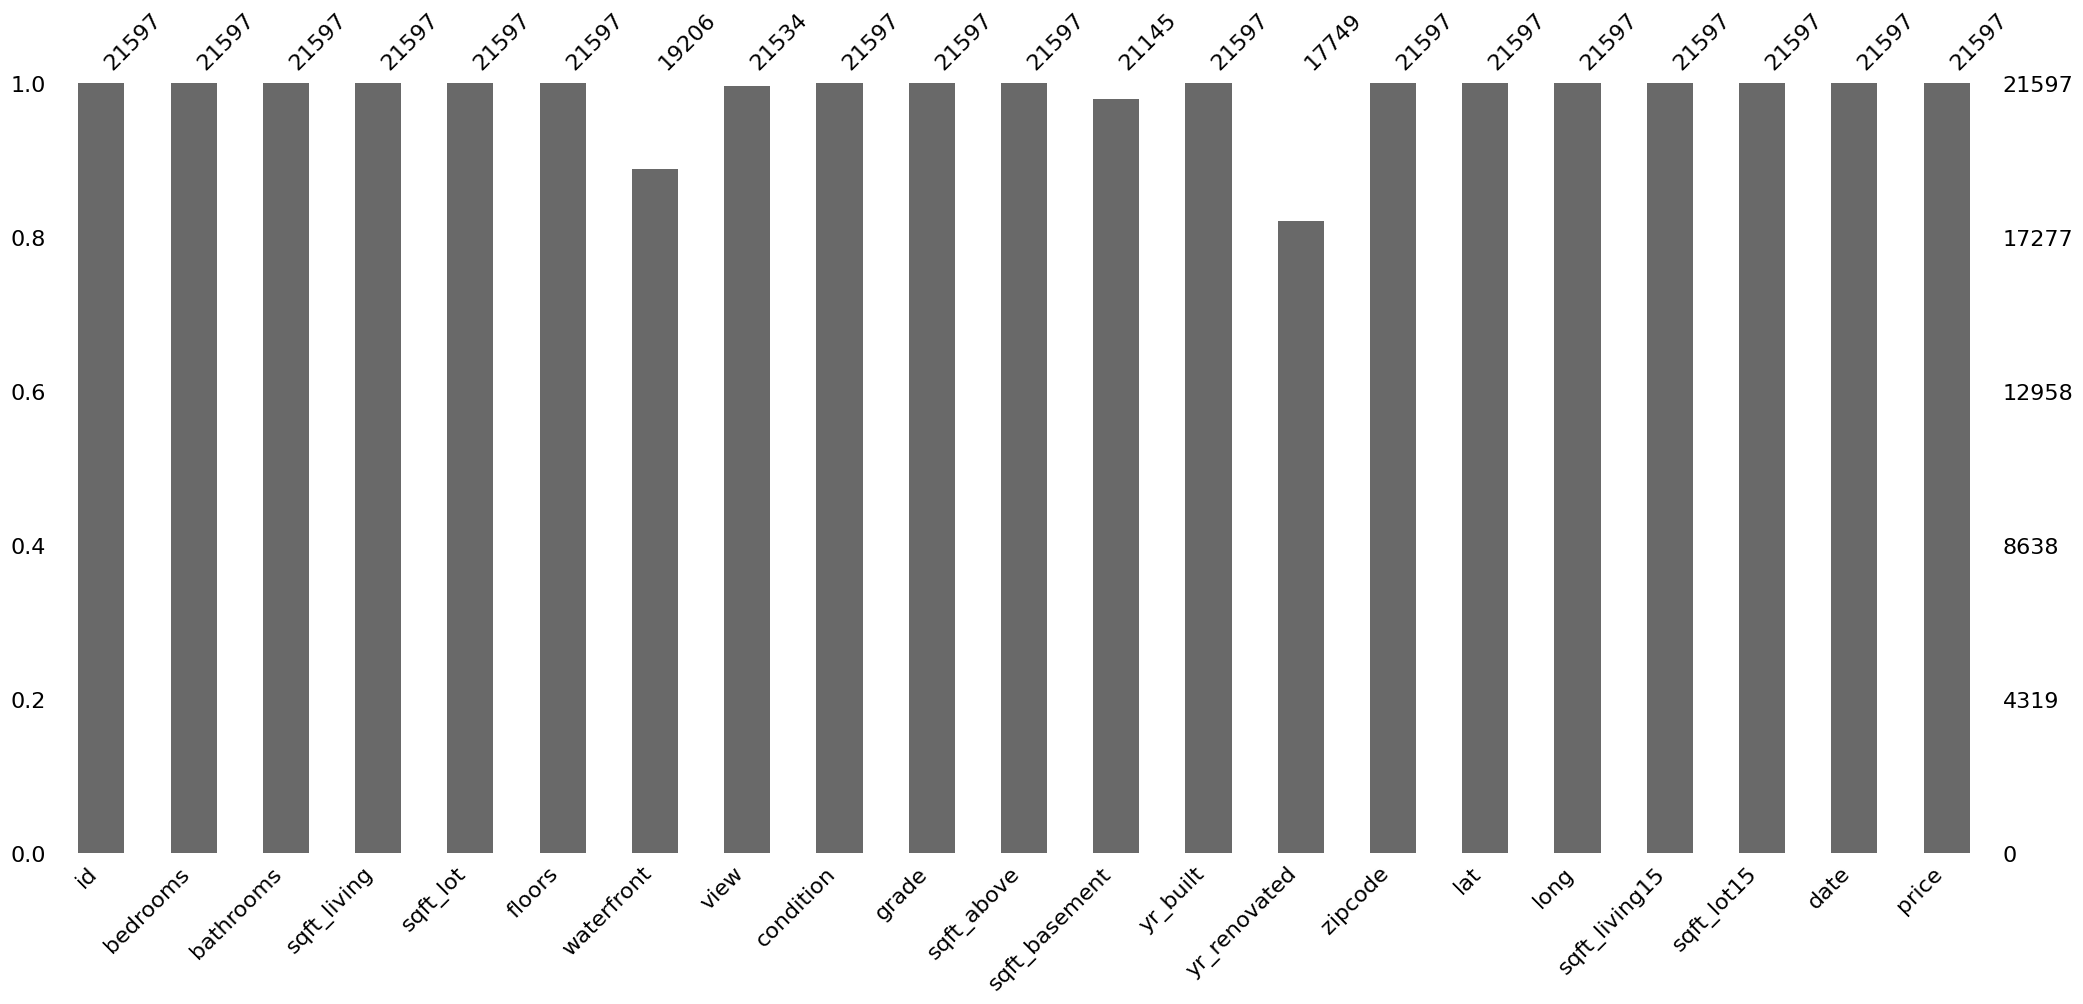

In [15]:
df_houses = pd.read_csv("data/eda.csv")
df_houses.head()
df_houses.info
df_houses.isna().sum()
msno.bar(df_houses)

In [16]:
# Plotting houses positions based on latitude and longitude
import plotly.express as px

fig = px.scatter_mapbox(df_houses, lat="lat", lon="long", hover_name="id",
    zoom=8,     # adjust zoom level
    height=600  # adjust area of map shown
    )
fig.update_traces(marker=dict(size=2, color="orange"))
fig.update_layout(mapbox_style="open-street-map")

fig.show()

First hypothesis to test \
How the proximity to Seattle influences the price of houses?\
Houses that are 5km away from the center of Seattle are 20% cheaper than houses inside a 5km radius from the center

In [17]:
# Look at price of houses located 5km away from the center of Seattle (use: lat, long and price columns)

# Limits of long and lat of Seattle 
center_lat_Seat = 47.6
center_long_Seat = -122.33

# Call function defining haversine formula
df_houses["dist_to_seattle_km"] = distance_haversine(center_lat_Seat, center_long_Seat, df_houses["lat"], df_houses["long"])

# Creating two databases for houses outside and inside 5km radius from center of Seattle
df_houses_5km_seatt = df_houses[(df_houses.loc[:, "dist_to_seattle_km"] > 5.0)]
df_houses_seatt = df_houses[(df_houses.loc[:, "dist_to_seattle_km"] < 5.0)]

df_houses_5km_seatt.shape
df_houses_seatt.shape

print("The mean price of houses that are 5km away from the center of Seattle is "+ str(round(df_houses_5km_seatt["price"].mean(),2)) + " dolars")
print("The mean price of houses that are inside a 5km radius from the center of Seattle is "+ str(round(df_houses_seatt["price"].mean(),2)) + " dolars")
price_diff = round(((df_houses_seatt["price"].mean()-df_houses_5km_seatt["price"].mean())*100)/(df_houses_seatt["price"].mean()), 2)
price_diff2 = round(((df_houses["price"].mean()-df_houses_5km_seatt["price"].mean())*100)/(df_houses["price"].mean()), 2)

print("Houses that are 5km away from the center of Seattle are " + str(price_diff) + "% cheaper than houses inside a 5km radius from the center")
print("Houses that are 5km away from the center of Seattle are " + str(price_diff2) + "% cheaper than houses in King County")

The mean price of houses that are 5km away from the center of Seattle is 527473.25 dolars
The mean price of houses that are inside a 5km radius from the center of Seattle is 735390.2 dolars
Houses that are 5km away from the center of Seattle are 28.27% cheaper than houses inside a 5km radius from the center
Houses that are 5km away from the center of Seattle are 2.37% cheaper than houses in King County


In [18]:
# Plotting houses positions based on latitude and longitude and 5k radius from center of Seattle

import plotly.graph_objects as go

# Radius in km
radius_km = 5
km_in_deg = 1/111  # Approximate: 1 degree ~ 111 km
radius_deg = radius_km * km_in_deg

# Create circle coordinates
angles = np.linspace(0, 2*np.pi, 100)
lats = center_lat_Seat + radius_deg * np.sin(angles)
lons = center_long_Seat + radius_deg * np.cos(angles)

fig = px.scatter_mapbox(df_houses, lat="lat", lon="long", hover_name="id",
    zoom=8,     # adjust zoom level
    height=500  # adjust area of map shown
    )
fig.update_traces(marker=dict(size=2, color="orange"))
fig.update_layout(mapbox_style="open-street-map")

# Add circle as a filled polygon
fig.add_trace(go.Scattermapbox(lon=lons, lat=lats, mode='lines', line=dict(color='red'),name="5 km radius"))

fig.show()

Second hypothesis to test\
Which houses are close to a golf course?\
The most expensive 25% of houses are in zip codes that always have at least one golf course

Most expensive houses are located in 63 zip codes
There are 28 zip codes where there is at least one golf course


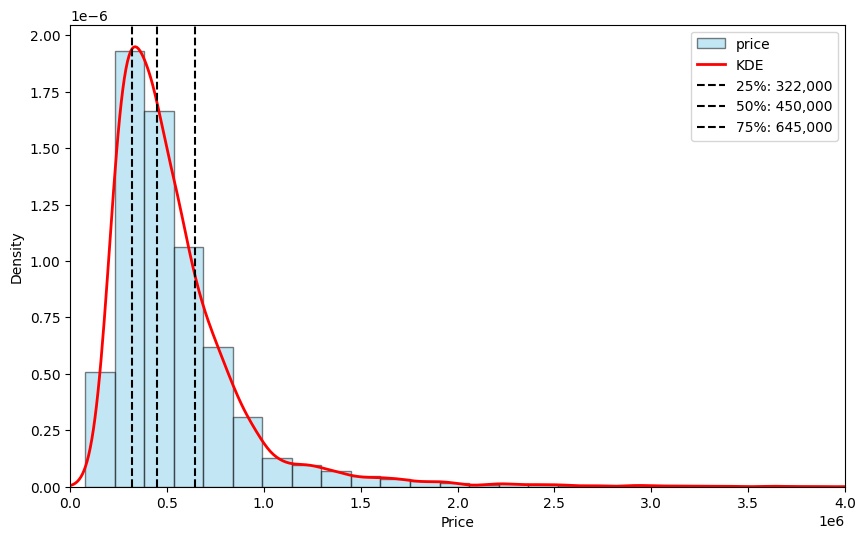

In [19]:
# Plot prices distribution 
from scipy.stats import gaussian_kde
ax = df_houses["price"].plot(kind="hist", bins=50, xlim=[0, 4000000], density=True, alpha=0.5,
    color="skyblue", edgecolor="black", figsize=(10,6))

# KDE (distribution line)
x_vals = np.linspace(0, 4000000, 500)
kde = gaussian_kde(df_houses["price"].dropna())
ax.plot(x_vals, kde(x_vals), color="red", linewidth=2, label="KDE")

# Quantiles
for q in [0.25, 0.5, 0.75]:
    val = df_houses["price"].quantile(q)
    ax.axvline(val, color="black", linestyle="--", label=f"{int(q*100)}%: {int(val):,}")

ax.set_xlabel("Price")
ax.set_ylabel("Density")
ax.legend()
plt.savefig("images/distribution_prices.png")

# Number of houses in 3rd quantile
q3_price = df_houses['price'].quantile(0.75)
more_than_q3 = df_houses['price'] > q3_price
more_than_q3.sum()

# Creating a database with the most expensive houses
df_houses_more_expensive = df_houses[(df_houses.loc[:, "price"] > q3_price)]
df_houses_more_expensive["zipcode"]

# Plot location of 25% more expensive houses

fig = px.scatter_mapbox(df_houses_more_expensive, lat="lat", lon="long", hover_name="id",
    zoom=8,     # adjust zoom level
    height=600  # adjust area of map shown
    )
fig.update_traces(marker=dict(size=4, color="red"))
fig.update_layout(mapbox_style="open-street-map")

fig.show()

# Creating a list of zip codes of the most expensive houses
df_houses_more_expensive_zipcode = df_houses_more_expensive["zipcode"].unique().tolist()

print("Most expensive houses are located in " + str(len(df_houses_more_expensive_zipcode)) + " zip codes")

# List of zip codes of golf courses in King County (Source: https://golftraxx.com/courses-by-zipcode?zipcode=98059&page=1)

golf_courses_zip = [98059, 98058, 98005, 98008, 98168, 98052, 98039, 98108, 98053, 98112, 98038,
    98188, 98126, 98042, 98014, 98032, 98115, 98024, 98103, 98119, 98065, 98072,
    98092, 98011, 98125, 98111, 98070, 98177, 98110, 98045, 98023, 98043, 98296,
    98003, 98422, 98390, 98366, 98036, 98012, 98311, 98372, 98346, 98332, 98272,
    98022, 98367, 98275, 98405, 98406, 98335, 98312, 98204, 98290, 98466, 98203,
    98467, 98360]

zip_codes_with_golf = [x for x in df_houses_more_expensive_zipcode if x in golf_courses_zip]
zip_codes_with_golf
print("There are " + str(len(zip_codes_with_golf))+ " zip codes where there is at least one golf course")

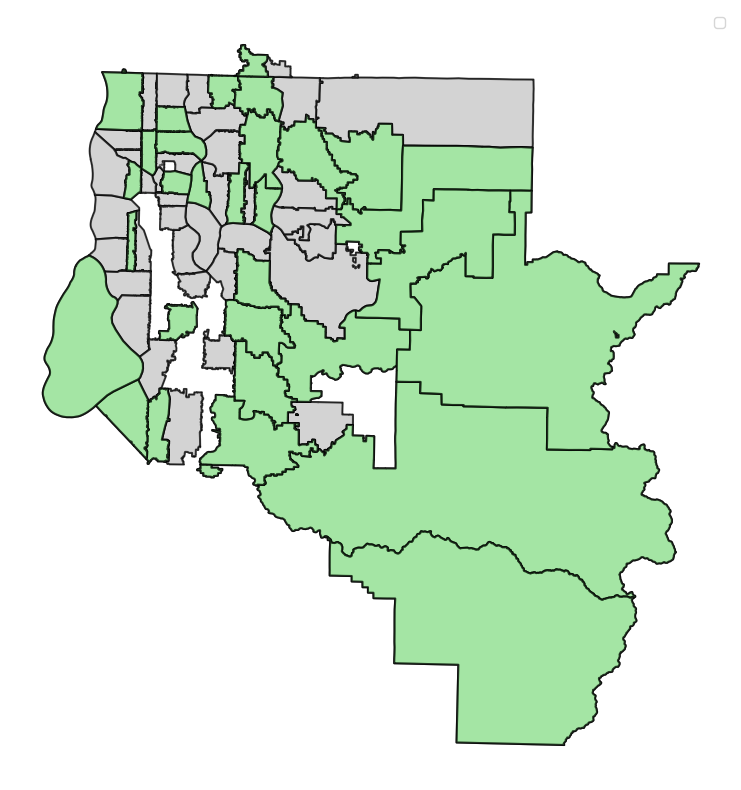

In [20]:
# Creating map of zip codes with at least a golf course

king_county_map = gpd.read_file("data/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.shp")
king_county_map=king_county_map.rename(columns=str.lower)
king_county_map['zipcode']= king_county_map['zipcode'].astype(str)

# Converting zip codes to integer
zip_codes_with_golf_str = [str(z) for z in zip_codes_with_golf]
df_houses_more_expensive_zipcode_str = [str(z) for z in df_houses_more_expensive_zipcode]

# Merging zip codes of both data
target_zipcodes = zip_codes_with_golf_str + df_houses_more_expensive_zipcode_str

# Create boolean columns for highlighting
king_county_map_center = king_county_map[king_county_map['zipcode'].isin(target_zipcodes)]

# Plot
fig, ax = plt.subplots(1, figsize=(12, 10))

# Plot all ZIP codes in light gray
king_county_map_center.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5)

# Overlay highlighted ZIP codes in different colors
king_county_map_center[king_county_map_center['zipcode'].isin(df_houses_more_expensive_zipcode_str)].plot(
    ax=ax, color='lightgray', edgecolor='black', linewidth=1.5, alpha=0.7, label='List 1'
)
king_county_map_center[king_county_map_center['zipcode'].isin(zip_codes_with_golf_str)].plot(
    ax=ax, color='lightgreen', edgecolor='black', linewidth=1.5, alpha=0.7, label='List 2'
)

plt.axis('off')
plt.legend()
plt.show()

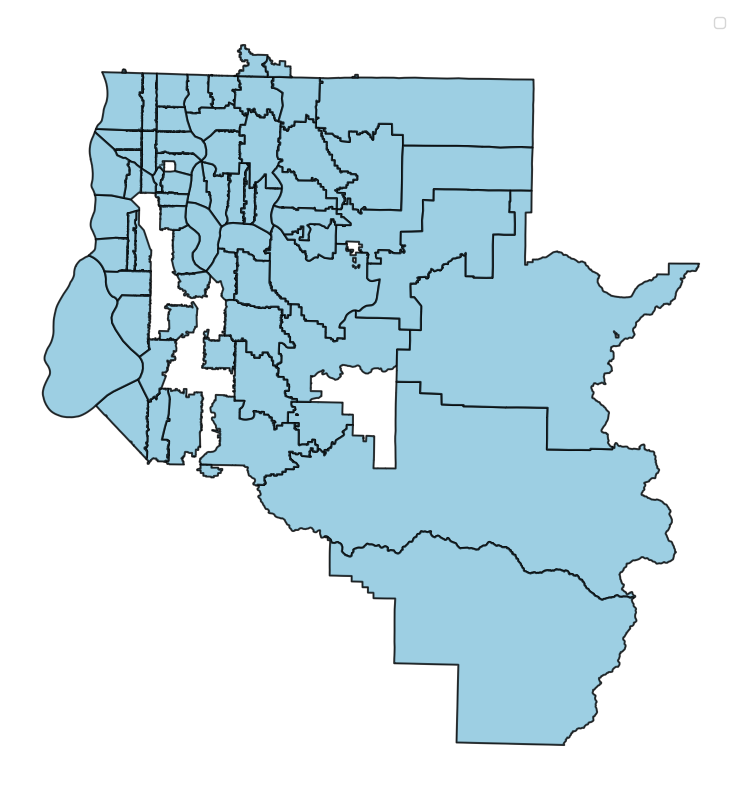

In [21]:
# Creating map of zip codes of most expensive houses
king_county_map = gpd.read_file("data/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.shp")
king_county_map=king_county_map.rename(columns=str.lower)
king_county_map['zipcode']= king_county_map['zipcode'].astype(str)

# Converting zip codes to integer
df_houses_more_expensive_zipcode_str = [str(z) for z in df_houses_more_expensive_zipcode]

# Create boolean columns for highlighting
king_county_map_center = king_county_map[king_county_map['zipcode'].isin(df_houses_more_expensive_zipcode_str)]

# Plot
fig, ax = plt.subplots(1, figsize=(12, 10))

# Plot all ZIP codes in light gray
king_county_map_center.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5)

# Overlay highlighted ZIP codes in different colors
king_county_map_center[king_county_map_center['zipcode'].isin(df_houses_more_expensive_zipcode_str)].plot(
    ax=ax, color='skyblue', edgecolor='black', linewidth=1.5, alpha=0.7, label='List 1'
)

plt.axis('off')
plt.legend()
plt.show()

In [22]:
df_import = df_houses
#List of houses that meet clients condition
conditions_df = df_import.query('bathrooms >=4 and waterfront == 0 and yr_built < 1975').copy()
conditions_df.loc[:,'sqft_outside'] = conditions_df['sqft_lot'] - conditions_df['sqft_living'] - conditions_df['sqft_basement'].fillna(0)

space_for_court_and_pool = 4800 + 800 #recommended tennis court 30x15m - about 4800sqft, residential pool 800sqft, olympic pool 13.123sqft
df_outside = conditions_df[conditions_df['sqft_outside'] > space_for_court_and_pool + 400].copy() #buffer space outside
df_outside['sqft_outside_left_after_cond'] = df_outside['sqft_outside'] - (space_for_court_and_pool + 400) #+ buffer

df_possible_houses  = df_outside.sort_values(by= 'sqft_outside_left_after_cond', ascending=False)

In [23]:
#Houses in the top25% price wise
average_price = df_import['price'].mean()
q3_price = df_import['price'].quantile(0.75)

more_than_mean = df_possible_houses['price'] > average_price
more_than_q3 = df_possible_houses['price'] > q3_price
more_than_q3.sum()
(~more_than_q3).sum() #calculate how many False

print( f"not more than mean: {(~more_than_mean).sum()}. not in q3: {(~more_than_q3).sum()}")

not more than mean: 1. not in q3: 4


In [24]:
#get seattle zipcodes
zipcodes_raw = """<list><div id="zipcodes" class="py-3 anchor-scroll"><div class="container"><h2>Seattle, WA has 60 ZIP Codes</h2><hr><div class="table-responsive"><table border="0" cellspacing="0" cellpadding="0" width="100%" class="table table-striped table-hover table-bordered small border rounded-3 overflow-hidden sortableTbl" id="tblZIP"><thead><tr><th nowrap="" class="header headerSortDown">ZIP Code</th><th class="header">Type</th><th axis="num" class="header"><span class="d-none d-md-block">Population</span><span class="d-block d-md-none d-lg-none">Pop</span></th><th class="header"><span class="d-none d-md-block">% of Population</span><span class="d-block d-md-none d-lg-none">% of Pop</span></th><th class="header">Alias Names</th></tr></thead><tbody><tr><td><a href="/zip-code/98101/zip-code-98101.asp" title="ZIP Code 98101">98101</a></td><td>Standard</td><td>16,237</td><td>1.60%</td><td>Times Square</td></tr><tr><td><a href="/zip-code/98102/zip-code-98102.asp" title="ZIP Code 98102">98102</a></td><td>Standard</td><td>25,066</td><td>2.46%</td><td>Broadway, Capitol Hill</td></tr><tr><td><a href="/zip-code/98103/zip-code-98103.asp" title="ZIP Code 98103">98103</a></td><td>Standard</td><td>53,056</td><td>5.21%</td><td>Greenwood, Wallingford</td></tr><tr><td><a href="/zip-code/98104/zip-code-98104.asp" title="ZIP Code 98104">98104</a></td><td>Standard</td><td>16,157</td><td>1.59%</td><td>International, Pioneer Square</td></tr><tr><td><a href="/zip-code/98105/zip-code-98105.asp" title="ZIP Code 98105">98105</a></td><td>Standard</td><td>49,151</td><td>4.83%</td><td>University</td></tr><tr><td><a href="/zip-code/98106/zip-code-98106.asp" title="ZIP Code 98106">98106</a></td><td>Standard</td><td>26,295</td><td>2.58%</td><td>White Center</td></tr><tr><td><a href="/zip-code/98107/zip-code-98107.asp" title="ZIP Code 98107">98107</a></td><td>Standard</td><td>28,557</td><td>2.81%</td><td>Ballard</td></tr><tr><td><a href="/zip-code/98108/zip-code-98108.asp" title="ZIP Code 98108">98108</a></td><td>Standard</td><td>25,009</td><td>2.46%</td><td>Tukwila</td></tr><tr><td><a href="/zip-code/98109/zip-code-98109.asp" title="ZIP Code 98109">98109</a></td><td>Standard</td><td>34,551</td><td>3.40%</td><td>Queen Anne</td></tr><tr><td><a href="/zip-code/98110/zip-code-98110.asp" title="ZIP Code 98110">98110</a></td><td>Standard</td><td>24,825</td><td>2.44%</td><td>Bainbridge Is, Seattle</td></tr><tr><td><a href="/zip-code/98111/zip-code-98111.asp" title="ZIP Code 98111">98111</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98112/zip-code-98112.asp" title="ZIP Code 98112">98112</a></td><td>Standard</td><td>23,152</td><td>2.28%</td><td>Madison Park</td></tr><tr><td><a href="/zip-code/98113/zip-code-98113.asp" title="ZIP Code 98113">98113</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98114/zip-code-98114.asp" title="ZIP Code 98114">98114</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98115/zip-code-98115.asp" title="ZIP Code 98115">98115</a></td><td>Standard</td><td>54,322</td><td>5.34%</td><td>Seattle Naval Support Activi, Wedgwood</td></tr><tr><td><a href="/zip-code/98116/zip-code-98116.asp" title="ZIP Code 98116">98116</a></td><td>Standard</td><td>27,691</td><td>2.72%</td><td>West Seattle</td></tr><tr><td><a href="/zip-code/98117/zip-code-98117.asp" title="ZIP Code 98117">98117</a></td><td>Standard</td><td>35,608</td><td>3.50%</td><td>Crown Hill</td></tr><tr><td><a href="/zip-code/98118/zip-code-98118.asp" title="ZIP Code 98118">98118</a></td><td>Standard</td><td>47,504</td><td>4.67%</td><td>Columbia</td></tr><tr><td><a href="/zip-code/98119/zip-code-98119.asp" title="ZIP Code 98119">98119</a></td><td>Standard</td><td>26,238</td><td>2.58%</td><td>Interbay</td></tr><tr><td><a href="/zip-code/98121/zip-code-98121.asp" title="ZIP Code 98121">98121</a></td><td>Standard</td><td>21,411</td><td>2.10%</td><td></td></tr><tr><td><a href="/zip-code/98122/zip-code-98122.asp" title="ZIP Code 98122">98122</a></td><td>Standard</td><td>41,646</td><td>4.09%</td><td>East Union</td></tr><tr><td><a href="/zip-code/98124/zip-code-98124.asp" title="ZIP Code 98124">98124</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98125/zip-code-98125.asp" title="ZIP Code 98125">98125</a></td><td>Standard</td><td>42,965</td><td>4.22%</td><td>Lake City, Northgate</td></tr><tr><td><a href="/zip-code/98126/zip-code-98126.asp" title="ZIP Code 98126">98126</a></td><td>Standard</td><td>23,727</td><td>2.33%</td><td>Westwood Village</td></tr><tr><td><a href="/zip-code/98127/zip-code-98127.asp" title="ZIP Code 98127">98127</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98129/zip-code-98129.asp" title="ZIP Code 98129">98129</a> <i class="fa-solid fa-building" title="Unique/Business ZIP Code"></i></td><td>Unique</td><td>0</td><td>0.00%</td><td>Reg Lib Handicapped</td></tr><tr><td><a href="/zip-code/98131/zip-code-98131.asp" title="ZIP Code 98131">98131</a></td><td>Standard</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98133/zip-code-98133.asp" title="ZIP Code 98133">98133</a></td><td>Standard</td><td>50,720</td><td>4.99%</td><td>Bitter Lake, Richmond Highlands, Shoreline</td></tr><tr><td><a href="/zip-code/98134/zip-code-98134.asp" title="ZIP Code 98134">98134</a></td><td>Standard</td><td>1,216</td><td>0.12%</td><td></td></tr><tr><td><a href="/zip-code/98136/zip-code-98136.asp" title="ZIP Code 98136">98136</a></td><td>Standard</td><td>16,424</td><td>1.61%</td><td>Westwood</td></tr><tr><td><a href="/zip-code/98138/zip-code-98138.asp" title="ZIP Code 98138">98138</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td>Tukwila</td></tr><tr><td><a href="/zip-code/98139/zip-code-98139.asp" title="ZIP Code 98139">98139</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98141/zip-code-98141.asp" title="ZIP Code 98141">98141</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98144/zip-code-98144.asp" title="ZIP Code 98144">98144</a></td><td>Standard</td><td>32,178</td><td>3.16%</td><td>Beacon Hill</td></tr><tr><td><a href="/zip-code/98145/zip-code-98145.asp" title="ZIP Code 98145">98145</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98146/zip-code-98146.asp" title="ZIP Code 98146">98146</a></td><td>Standard</td><td>28,845</td><td>2.84%</td><td>Burien, Shorewood, White Center</td></tr><tr><td><a href="/zip-code/98148/zip-code-98148.asp" title="ZIP Code 98148">98148</a></td><td>Standard</td><td>11,092</td><td>1.09%</td><td>Burien, Des Moines, Normandy Park, Seatac</td></tr><tr><td><a href="/zip-code/98154/zip-code-98154.asp" title="ZIP Code 98154">98154</a></td><td>Standard</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98155/zip-code-98155.asp" title="ZIP Code 98155">98155</a></td><td>Standard</td><td>35,948</td><td>3.53%</td><td>Forest Park, Lake Forest Park, Lk Forest Park, Lk Forest Pk, North City, Shoreline</td></tr><tr><td><a href="/zip-code/98158/zip-code-98158.asp" title="ZIP Code 98158">98158</a></td><td>Standard</td><td>0</td><td>0.00%</td><td>Seatac, Seatac Airport</td></tr><tr><td><a href="/zip-code/98160/zip-code-98160.asp" title="ZIP Code 98160">98160</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td>Richmond Beach</td></tr><tr><td><a href="/zip-code/98161/zip-code-98161.asp" title="ZIP Code 98161">98161</a></td><td>Standard</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98164/zip-code-98164.asp" title="ZIP Code 98164">98164</a></td><td>Standard</td><td>176</td><td>0.02%</td><td></td></tr><tr><td><a href="/zip-code/98165/zip-code-98165.asp" title="ZIP Code 98165">98165</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98166/zip-code-98166.asp" title="ZIP Code 98166">98166</a></td><td>Standard</td><td>22,152</td><td>2.18%</td><td>Burien, Normandy Park</td></tr><tr><td><a href="/zip-code/98168/zip-code-98168.asp" title="ZIP Code 98168">98168</a></td><td>Standard</td><td>36,389</td><td>3.58%</td><td>Burien, Seatac, Tukwila</td></tr><tr><td><a href="/zip-code/98170/zip-code-98170.asp" title="ZIP Code 98170">98170</a> <i class="fa-solid fa-building" title="Unique/Business ZIP Code"></i></td><td>Unique</td><td>0</td><td>0.00%</td><td>Amazon.com</td></tr><tr><td><a href="/zip-code/98174/zip-code-98174.asp" title="ZIP Code 98174">98174</a></td><td>Standard</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98175/zip-code-98175.asp" title="ZIP Code 98175">98175</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98177/zip-code-98177.asp" title="ZIP Code 98177">98177</a></td><td>Standard</td><td>20,160</td><td>1.98%</td><td>Bitter Lake, Richmond Beach, Shoreline, The Highlands</td></tr><tr><td><a href="/zip-code/98178/zip-code-98178.asp" title="ZIP Code 98178">98178</a></td><td>Standard</td><td>26,122</td><td>2.57%</td><td>Bryn Mawr, Skyway, Tukwila</td></tr><tr><td><a href="/zip-code/98181/zip-code-98181.asp" title="ZIP Code 98181">98181</a> <i class="fa-solid fa-building" title="Unique/Business ZIP Code"></i></td><td>Unique</td><td>0</td><td>0.00%</td><td>Macys</td></tr><tr><td><a href="/zip-code/98185/zip-code-98185.asp" title="ZIP Code 98185">98185</a> <i class="fa-solid fa-building" title="Unique/Business ZIP Code"></i></td><td>Unique</td><td>0</td><td>0.00%</td><td>Safeco Plaza</td></tr><tr><td><a href="/zip-code/98188/zip-code-98188.asp" title="ZIP Code 98188">98188</a></td><td>Standard</td><td>27,851</td><td>2.74%</td><td>Duwamish, Mcmicken Heights, Riverton, Seatac, Tukwila</td></tr><tr><td><a href="/zip-code/98190/zip-code-98190.asp" title="ZIP Code 98190">98190</a> <i class="fa-solid fa-building" title="Unique/Business ZIP Code"></i></td><td>Unique</td><td>0</td><td>0.00%</td><td>Capital One</td></tr><tr><td><a href="/zip-code/98191/zip-code-98191.asp" title="ZIP Code 98191">98191</a> <i class="fa-solid fa-building" title="Unique/Business ZIP Code"></i></td><td>Unique</td><td>0</td><td>0.00%</td><td>Qwest</td></tr><tr><td><a href="/zip-code/98194/zip-code-98194.asp" title="ZIP Code 98194">98194</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98195/zip-code-98195.asp" title="ZIP Code 98195">98195</a> <i class="fa-solid fa-building" title="Unique/Business ZIP Code"></i></td><td>Unique</td><td>3,710</td><td>0.36%</td><td>Univ Of Washington</td></tr><tr><td><a href="/zip-code/98198/zip-code-98198.asp" title="ZIP Code 98198">98198</a></td><td>Standard</td><td>38,727</td><td>3.81%</td><td>Des Moines, Normandy Park, Redondo Beach, Seatac</td></tr><tr><td><a href="/zip-code/98199/zip-code-98199.asp" title="ZIP Code 98199">98199</a></td><td>Standard</td><td>22,549</td><td>2.22%</td><td>Fort Lawton, Magnolia</td></tr></tbody></table></div><ins class="adsbygoogle container" style="display:block" data-ad-client="ca-pub-6449469715038723" data-ad-slot="9841517722" data-ad-format="auto" data-full-width-responsive="true" data-adsbygoogle-status="done"><iframe id="aswift_1" style="height: 1px !important; max-height: 1px !important; max-width: 1px !important; width: 1px !important;"><iframe id="google_ads_frame1"></iframe></iframe></ins></div></div></list>"""
pattern = r'zip-code/(\d{5})/'
seattle_zipcodes = re.findall(pattern, zipcodes_raw)
zips = pd.DataFrame(seattle_zipcodes, columns= ['zipcode'])

In [25]:
#amount of selected houses in seattle
houses_in_seattle = df_possible_houses[df_possible_houses['zipcode'].astype(str).isin(seattle_zipcodes)]
houses_in_seattle.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,dist_to_seattle_km,sqft_outside,sqft_outside_left_after_cond
count,15.000,15.000,15.000,15.000,15.000,15.000,15.000,15.000,15.000,15.000,...,12.000,15.000,15.000,15.000,15.000,15.000,15.000,15.000,15.000,15.000
mean,3934193808.667,4.800,4.883,5501.667,29180.667,2.000,0.000,1.867,3.933,10.800,...,4999.167,98149.867,47.626,-122.326,3244.000,25956.467,2480800.000,10.877,22584.333,16584.333
std,2923513674.349,1.082,1.187,2554.666,17964.521,0.598,0.000,1.552,0.799,1.740,...,9043.970,36.451,0.107,0.049,1019.529,33938.550,1724196.384,6.192,17340.447,17340.447
min,239000155.000,3.000,4.000,1400.000,8580.000,1.000,0.000,0.000,3.000,7.000,...,0.000,98102.000,47.427,-122.408,1220.000,6477.000,265000.000,3.355,6525.000,525.000
25%,1225650776.500,4.000,4.125,4030.000,17124.000,2.000,0.000,0.000,3.000,10.000,...,0.000,98112.000,47.598,-122.374,2785.000,9259.500,1645000.000,4.816,9314.000,3314.000
50%,3585900500.000,5.000,4.500,4720.000,24085.000,2.000,0.000,2.000,4.000,11.000,...,0.000,98166.000,47.638,-122.311,3750.000,12040.000,2530000.000,9.404,17077.000,11077.000
75%,5348451361.000,5.500,4.875,6755.000,35892.000,2.500,0.000,3.000,4.500,12.000,...,4967.500,98177.000,47.700,-122.286,3950.000,23200.000,2905000.000,16.495,28552.000,22552.000
max,9471200200.000,7.000,8.000,12050.000,67953.000,3.000,0.000,4.000,5.000,13.000,...,20100.000,98199.000,47.761,-122.260,4410.000,128066.000,7700000.000,19.556,64093.000,58093.000


For more lenient conditions

In [26]:
houses_in_seattle = df_import[df_import['zipcode'].isin(seattle_zipcodes)]

lesser_condition_in_seattle = df_import.query('bathrooms >=3 and waterfront == 0 and yr_built < 1975').copy()
lesser_condition_in_seattle.loc[:,'sqft_outside'] = lesser_condition_in_seattle['sqft_lot'] - lesser_condition_in_seattle['sqft_living'] - lesser_condition_in_seattle['sqft_basement'].fillna(0)


df_lesser_houses = lesser_condition_in_seattle[lesser_condition_in_seattle['sqft_outside'] > space_for_court_and_pool + 400].copy()

df_lesser_houses['sqft_outside_left_after_cond'] = df_lesser_houses['sqft_outside'] - (space_for_court_and_pool + 400)
df_lesser_houses.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,dist_to_seattle_km,sqft_outside,sqft_outside_left_after_cond
count,173.000,173.000,173.000,173.000,173.000,173.000,173.000,173.000,173.000,173.000,...,139.000,173.000,173.000,173.000,173.000,173.000,173.000,173.000,173.000,173.000
mean,4419084551.832,4.509,3.432,3530.925,29660.931,1.532,0.000,0.913,3.717,8.740,...,6618.129,98071.428,47.590,-122.233,2722.017,21530.861,1174958.642,14.448,25423.029,19423.029
std,2737925789.925,0.974,0.680,1275.823,44692.775,0.518,0.000,1.329,0.759,1.362,...,9444.432,62.222,0.110,0.097,785.149,30098.345,894296.631,6.861,44792.606,44792.606
min,114100745.000,2.000,3.000,1400.000,8170.000,1.000,0.000,0.000,3.000,6.000,...,0.000,98001.000,47.284,-122.504,1220.000,4950.000,255000.000,3.355,6085.000,85.000
25%,2025059131.000,4.000,3.000,2720.000,11920.000,1.000,0.000,0.000,3.000,8.000,...,0.000,98011.000,47.534,-122.295,2120.000,10230.000,575000.000,9.307,8396.000,2396.000
50%,3627800050.000,4.000,3.250,3380.000,16224.000,1.500,0.000,0.000,4.000,8.000,...,0.000,98040.000,47.591,-122.229,2640.000,13113.000,895000.000,13.244,11800.000,5800.000
75%,6744700343.000,5.000,3.500,4020.000,28300.000,2.000,0.000,2.000,4.000,10.000,...,19940.000,98118.000,47.652,-122.173,3340.000,20000.000,1530000.000,18.327,24366.000,18366.000
max,9808100100.000,8.000,8.000,12050.000,443440.000,3.000,0.000,4.000,5.000,13.000,...,20150.000,98199.000,47.776,-122.000,4480.000,298182.000,7700000.000,35.208,440740.000,434740.000


In [27]:
# range in which the houses in their zipcode area were built
range_built_yrs = df_import.groupby('zipcode').agg(range=('yr_built',lambda x:x.max()-x.min()))
print(range_built_yrs.describe())

df_import_range = df_import.merge(range_built_yrs, on = 'zipcode',how='left')

        range
count  70.000
mean  104.386
std    13.951
min    54.000
25%   101.250
50%   110.000
75%   114.000
max   115.000


In [28]:
#added addresses
geo = Nominatim(user_agent='phillips')
def get_address(row):
    location = geo.reverse((row['lat'], row['long']))
    return location.address if location else None

df_possible_houses['address'] = df_possible_houses.apply(get_address, axis = 1)

geographical map generation

In [29]:
#king county info geodataframe
king_county_map = gpd.read_file("data/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.shp")

king_county_map=king_county_map.rename(columns=str.lower)
king_county_map['zipcode']= king_county_map['zipcode'].astype(str)
df_import['zipcode']= df_import['zipcode'].astype(str)
df_import_range['zipcode']= df_import_range['zipcode'].astype(str)

map_and_stats = king_county_map.merge(df_import_range, on = 'zipcode')



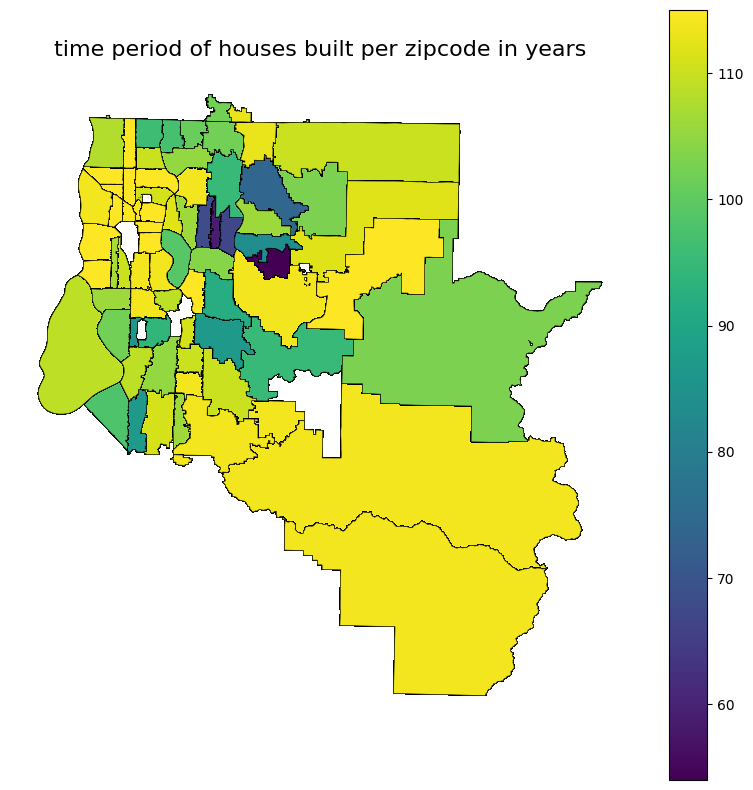

In [30]:
#map of range of years in which houses were built per zipcode
fig, ax = plt.subplots(1, figsize=(10,10))
map_and_stats.plot(column='range', cmap='viridis',linewidth=0.4,ax=ax,legend=True, edgecolor= 'black')

ax.set_axis_off()
plt.title('time period of houses built per zipcode in years',size=16)
plt.show()

Text(0.5, 1.0, 'Year of the latest built house per zipcode')

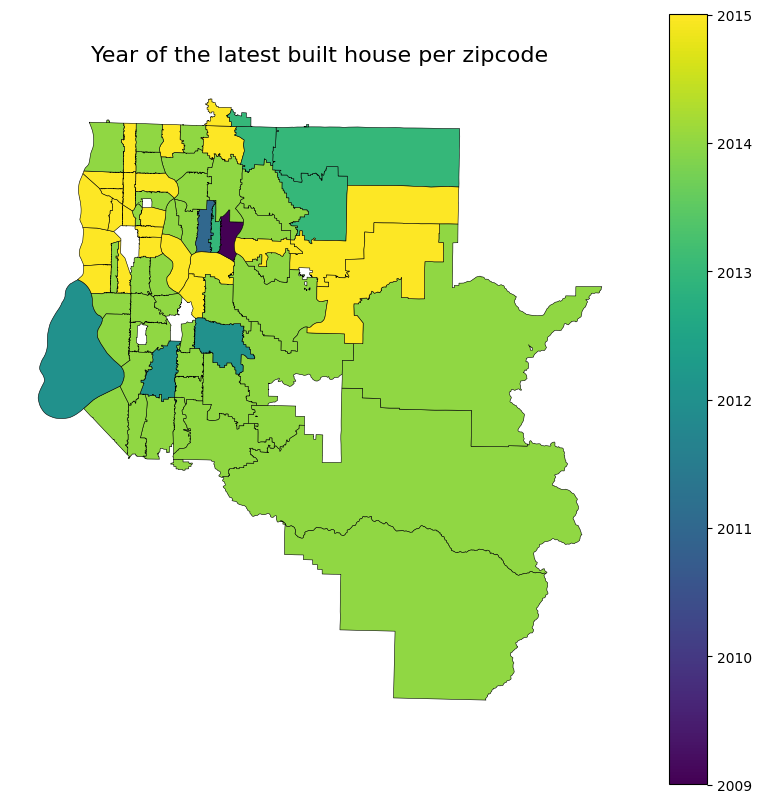

In [31]:
# newest built houses
max_years = df_import.groupby('zipcode', as_index=False).agg(max_year=('yr_built','max'))

max_years['zipcode']= max_years['zipcode'].astype(str)

map_and_stats = king_county_map.merge(max_years, on = 'zipcode')

fig, ax = plt.subplots(1, figsize=(10,10))

map_and_stats.plot(column='max_year', cmap='viridis',linewidth=0.4,ax=ax,legend=True,edgecolor= 'black')

ax.set_axis_off()

plt.title('Year of the latest built house per zipcode', fontsize= 16)

Text(0.5, 1.0, 'Built year of the oldest house per zipcode')

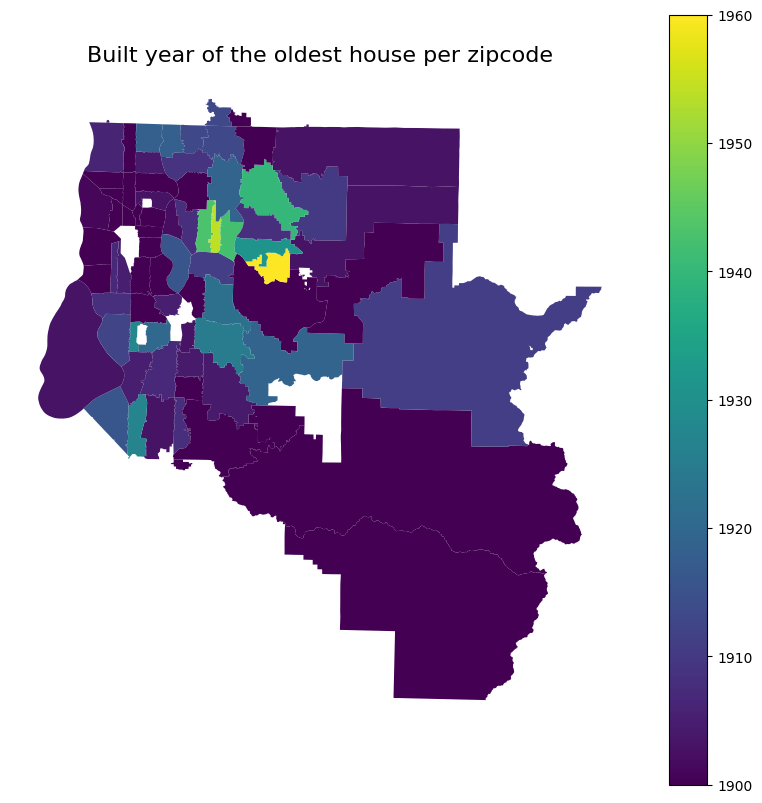

In [32]:
#oldest built houses
min_years = df_import.groupby('zipcode', as_index=False).agg(min_year=('yr_built','min'))

min_years['zipcode']= min_years['zipcode'].astype(str)

map_and_stats = king_county_map.merge(min_years, on = 'zipcode')

fig, ax = plt.subplots(1, figsize=(10,10))

map_and_stats.plot(column='min_year', cmap='viridis',linewidth=0.4,ax=ax,legend=True)

ax.set_axis_off()
plt.title('Built year of the oldest house per zipcode', fontsize= 16)

In [33]:
#golf courses
golf_course_zips = [98053,98126,98119,98112,98052,98115,98070,98008,98005,98177,98103,98059,98038,98024,98125,98065,98072,98092,98045,98022,98003,98042,98014,98039,98058,98023,98011,98188]


df_import['zipcode'].isin(golf_course_zips).sum()
df_possible_houses['zipcode'].isin(golf_course_zips).sum()

np.int64(11)

In [34]:
# Area of Seattle
seattle = king_county_map.query('preferred_ == "SEATTLE"')
seattle_zips = [str(zipcode) for zipcode in seattle['zipcode']]

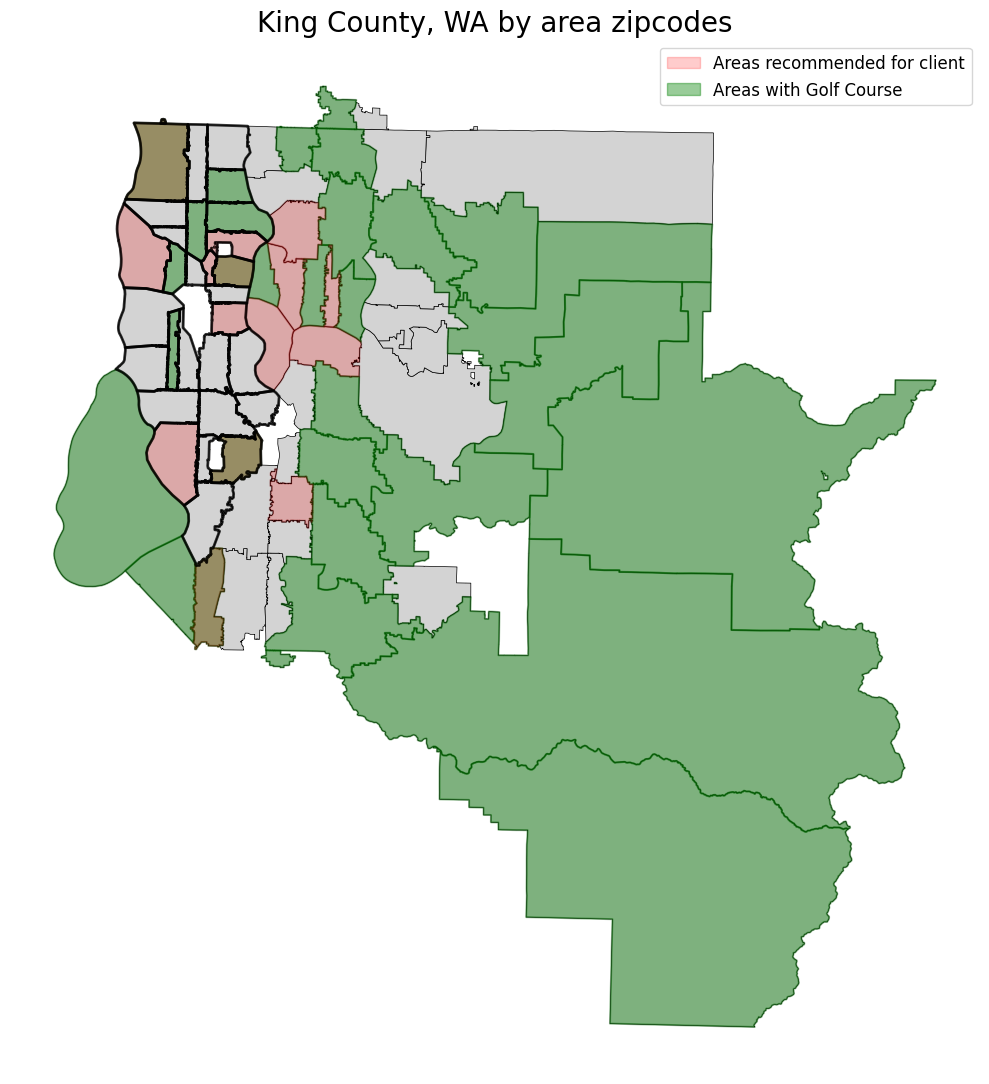

In [35]:
#Map of Zipcodes with golf courses and our 26 houses with marked seattle border
map_and_stats['seattle_highlight'] = map_and_stats['zipcode'].isin(seattle_zips)

target_zipcodes = [str(zipcode) for zipcode in df_possible_houses['zipcode']]
golf_course_zips = [str(zipcode) for zipcode in golf_course_zips]


map_and_stats['houses_highlight'] = map_and_stats['zipcode'].isin(target_zipcodes)
map_and_stats['golf_highlight'] = map_and_stats['zipcode'].isin(golf_course_zips)


fig, ax = plt.subplots(1, figsize=(10, 20))

#all zipcodes 
map_and_stats.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5)

#golf course zipcodes
golf_highlighted = map_and_stats[map_and_stats['golf_highlight']]
golf_highlighted.plot(ax=ax, color='green', edgecolor='darkgreen', linewidth=1.5, alpha=0.4)

# house zipcodes
house_highlighted = map_and_stats[map_and_stats['houses_highlight']]
house_highlighted.plot(ax=ax, color='red', edgecolor='darkred', linewidth=1.5, alpha=0.2)

#seattle
seattle_outlined = map_and_stats[map_and_stats['seattle_highlight']]
seattle_outlined.plot(ax=ax, color='none', edgecolor='black', linewidth=2,alpha=0.8)

#legend
house_patch = mpatches.Patch(color='red', label='Areas recommended for client', alpha=0.2)
golf_patch = mpatches.Patch(color='green', label='Areas with Golf Course', alpha=0.4)


plt.legend(handles=[house_patch, golf_patch], loc='upper right', fontsize = 12)

plt.title('King County, WA by area zipcodes', fontsize= 20 )
plt.axis('off')
plt.tight_layout()
plt.show()

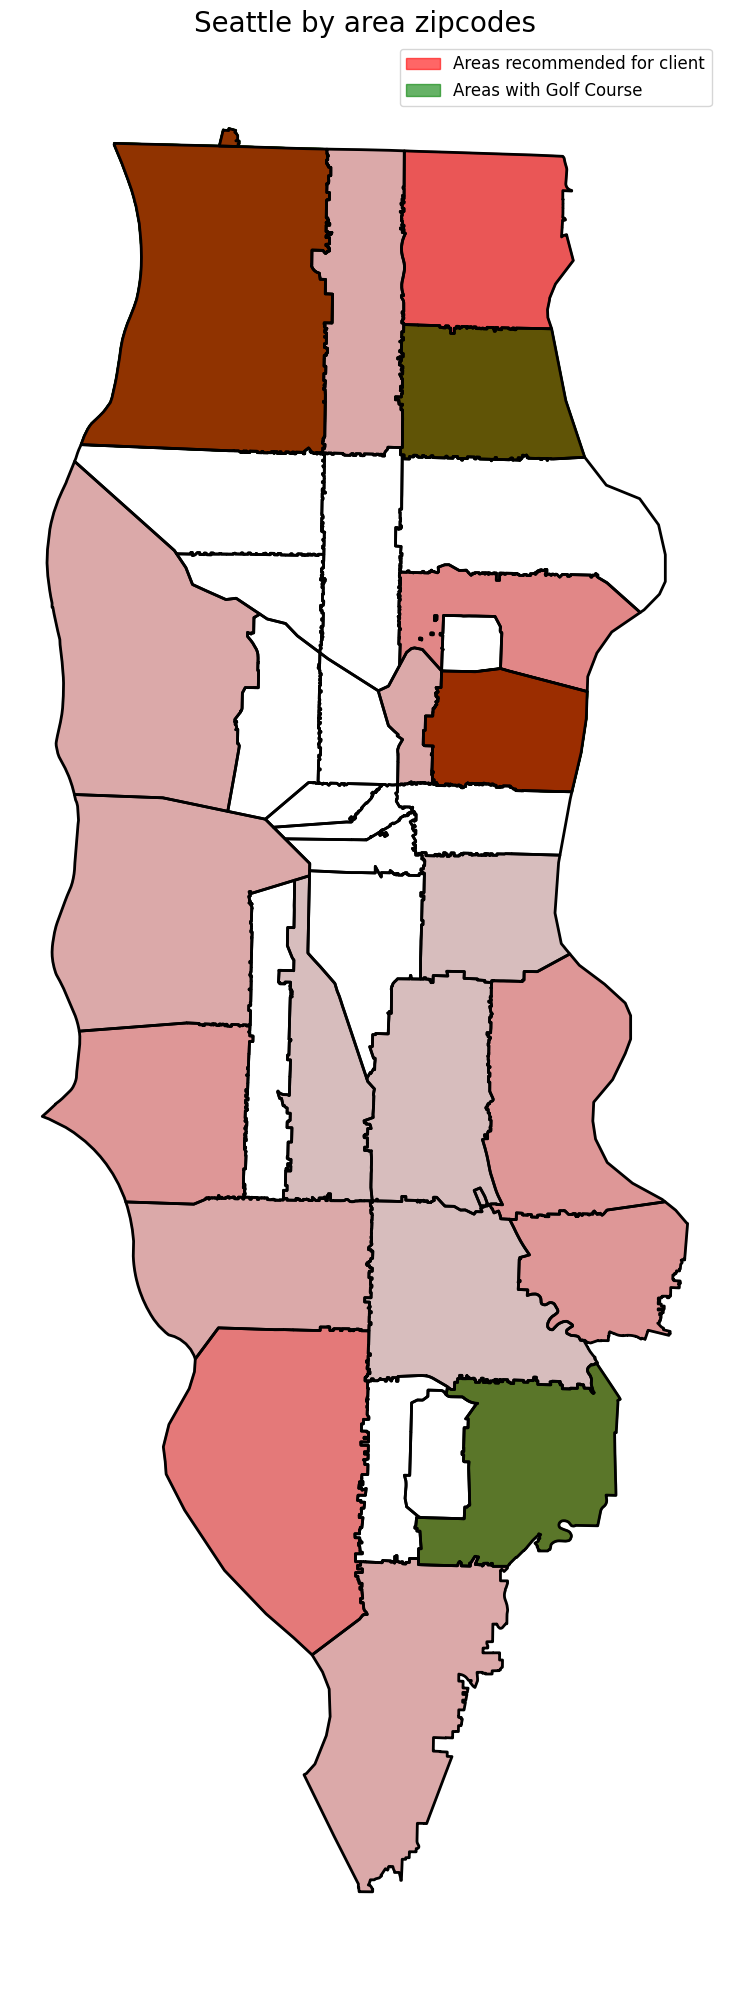

In [36]:
# 2+ bathroom condition mapped Seattle
df_lesser_houses['zipcode']= df_lesser_houses['zipcode'].astype(str)

mapstats_lesser = seattle.merge(df_lesser_houses, on = 'zipcode')

mapstats_lesser['seattle_highlight'] = mapstats_lesser['zipcode'].isin(seattle_zips)

target_zipcodes = [str(zipcode) for zipcode in df_lesser_houses['zipcode']]
golf_course_zips = [str(zipcode) for zipcode in golf_course_zips]


mapstats_lesser['houses_highlight'] = mapstats_lesser['zipcode'].isin(target_zipcodes)
mapstats_lesser['golf_highlight'] = mapstats_lesser['zipcode'].isin(golf_course_zips)


fig, ax = plt.subplots(1, figsize=(20, 20))

#all zipcodes 
mapstats_lesser.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5)

#golf course zipcodes
golf_highlighted = mapstats_lesser[mapstats_lesser['golf_highlight']]
golf_highlighted.plot(ax=ax, color='green', edgecolor='darkgreen', linewidth=1.5,alpha=0.5)

# lesser house zipcodes
house_highlighted = mapstats_lesser[mapstats_lesser['houses_highlight']]
house_highlighted.plot(ax=ax, color='red', edgecolor='darkred', linewidth=1.5, alpha= 0.1)

#seattle
seattle.plot(ax=ax, color='none', edgecolor='black', linewidth=2)

house_patch = mpatches.Patch(color='red', label='Areas recommended for client', alpha=0.6)
golf_patch = mpatches.Patch(color='green', label='Areas with Golf Course', alpha=0.6)


plt.legend(handles=[house_patch, golf_patch], loc='upper right', fontsize = 12)

plt.title('Seattle by area zipcodes', fontsize= 20 )
plt.axis('off')
plt.tight_layout()
plt.show()

Version 2 for Seattle area

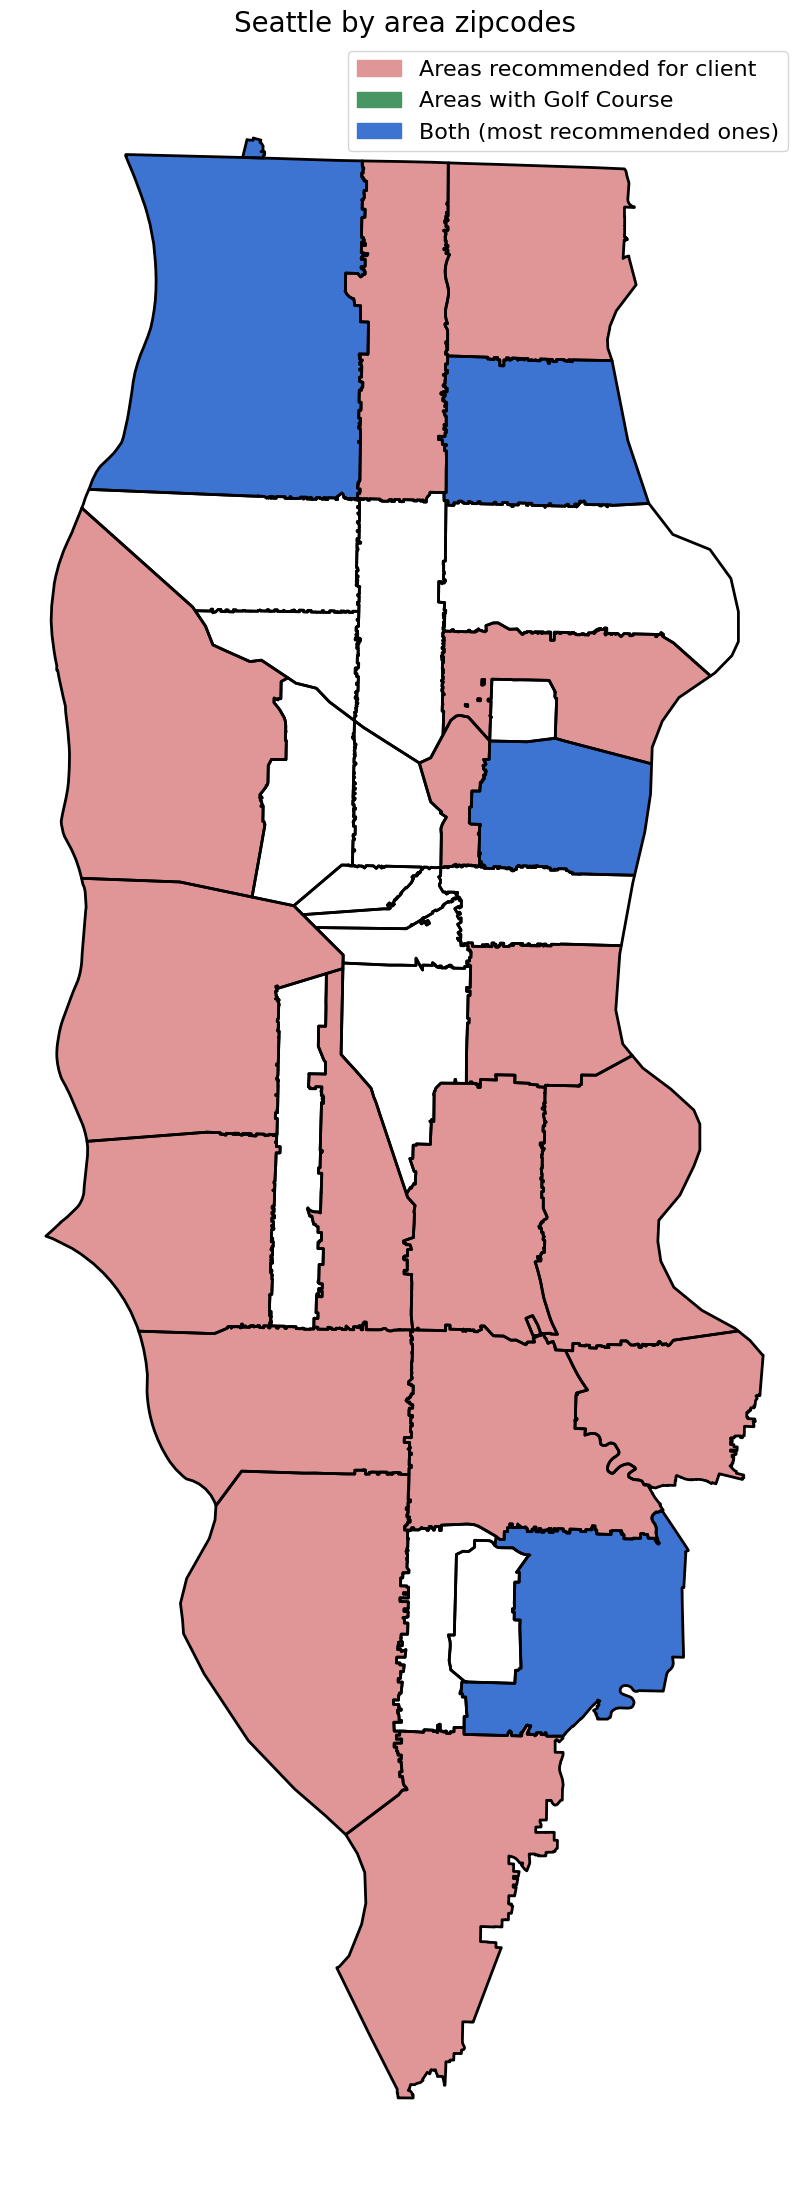

In [37]:
#Define a category column based on the combination of highlights
def get_category(row):
    if row['houses_highlight'] and row['golf_highlight']:
        return 'both'
    elif row['houses_highlight']:
        return 'houses'
    elif row['golf_highlight']:
        return 'golf'
    else:
        return 'other'

mapstats_lesser['category'] = mapstats_lesser.apply(get_category, axis=1)

#Define colors for each category
color_map = {
    'houses': '#e09696',  # red
    'golf': '#479663',    # green
    'both': '#3d73d1',    # orange
    'other': '#D3D3D3'    # light gray
}

#Plot using the categorical column
fig, ax = plt.subplots(1, figsize=(24, 28))
mapstats_lesser.plot(ax=ax,
                     color=mapstats_lesser['category'].map(color_map),
                     edgecolor='black',
                     linewidth=0.5)

#Outline Seattle boundary
seattle.plot(ax=ax, color='none', edgecolor='black', linewidth=2)

#Legend
house_patch = mpatches.Patch(color='#e09696', label='Areas recommended for client')
golf_patch = mpatches.Patch(color='#479663', label='Areas with Golf Course')
overlap_patch = mpatches.Patch(color='#3d73d1', label='Both (most recommended ones)')
plt.legend(handles=[house_patch, golf_patch, overlap_patch], loc='best', fontsize=16)

plt.title('Seattle by area zipcodes', fontsize=20)
plt.axis('off')
plt.show()